In [1]:
import json

# import os
import sys

import optax
import numpy as np
import jax.numpy as jnp

import jVMC
from jVMC import nets
from jVMC import operator as op
from jVMC import sampler
from jVMC.vqs import NQS
# from jVMC.util import h5SaveParams, NaturalGradient
import h5py as h5

# plotting
import matplotlib.pyplot as plt

import jax
from jax import config
config.update("jax_enable_x64", True)
import jax.random as jrnd

from jVMC.nets.RWKV import CpxRWKV

In [2]:
config = {
    "L":8,
    "T":0,
    "H":8,
    "numSamples":2**11,
    "small_I_lr":3e-1,
    "N":50,
    "natural_gradient":True,
    "OutDir":"./",
    "net":"rbm",
    "boundary_conditions":"obc",
    "seed":10030,
    "File":"/Users/rigo/TrainingData/ising_N=20_t=0-3-300_k=0.25_g=1.0_h=0.0-001.h5"
}

In [3]:
############################
# loading data

L = config["L"] # number of spins
N = config["N"] # number of iterations
T = config["T"] # time idndex
H = config["H"] # number of hidden units
numSamples = config["numSamples"] # number of samples
natural_gradient = config["natural_gradient"] # natural gradient bool
seed = config["seed"] # random seed

############################
# loading data
data_at_time = abs(np.random.randn(2**L))
data_at_time += data_at_time[::-1]
data_at_time /= np.sqrt(np.sum(data_at_time**2))

In [4]:
############################
# setting up the target WF
"""
chi_model = nets.Target(L=L, d=2)
chi = NQS(chi_model, batchSize=256)
chi(jnp.array(jnp.ones((1, 1, L))))
chi.set_parameters(jnp.array(data_at_time) + 1e-14)

chiSampler = sampler.MCSampler(
    chi,
    (L,),
    jrnd.PRNGKey(seed),
    updateProposer=jVMC.sampler.propose_spin_flip,
    numChains=20,
    sweepSteps=L,
    numSamples=numSamples,
    thermalizationSweeps=25,
)
"""

'\nchi_model = nets.Target(L=L, d=2)\nchi = NQS(chi_model, batchSize=256)\nchi(jnp.array(jnp.ones((1, 1, L))))\nchi.set_parameters(jnp.array(data_at_time) + 1e-14)\n\nchiSampler = sampler.MCSampler(\n    chi,\n    (L,),\n    jrnd.PRNGKey(seed),\n    updateProposer=jVMC.sampler.propose_spin_flip,\n    numChains=20,\n    sweepSteps=L,\n    numSamples=numSamples,\n    thermalizationSweeps=25,\n)\n'

In [5]:
psi = NQS(CpxRWKV(L = L, num_layers=2, embedding_size=4,hidden_size=H,num_heads=4,bias=True,one_hot=True), batchSize=2**3)
psiSampler = jVMC.sampler.MCSampler(psi,(L,),jrnd.PRNGKey(seed))

paras = psi.get_parameters()

psi(np.ones(L,dtype=int).reshape(1,1,L))

Array([[-1.26263264-0.40623421j]], dtype=complex128)

In [6]:
psi.set_parameters(1000. * paras)

[]

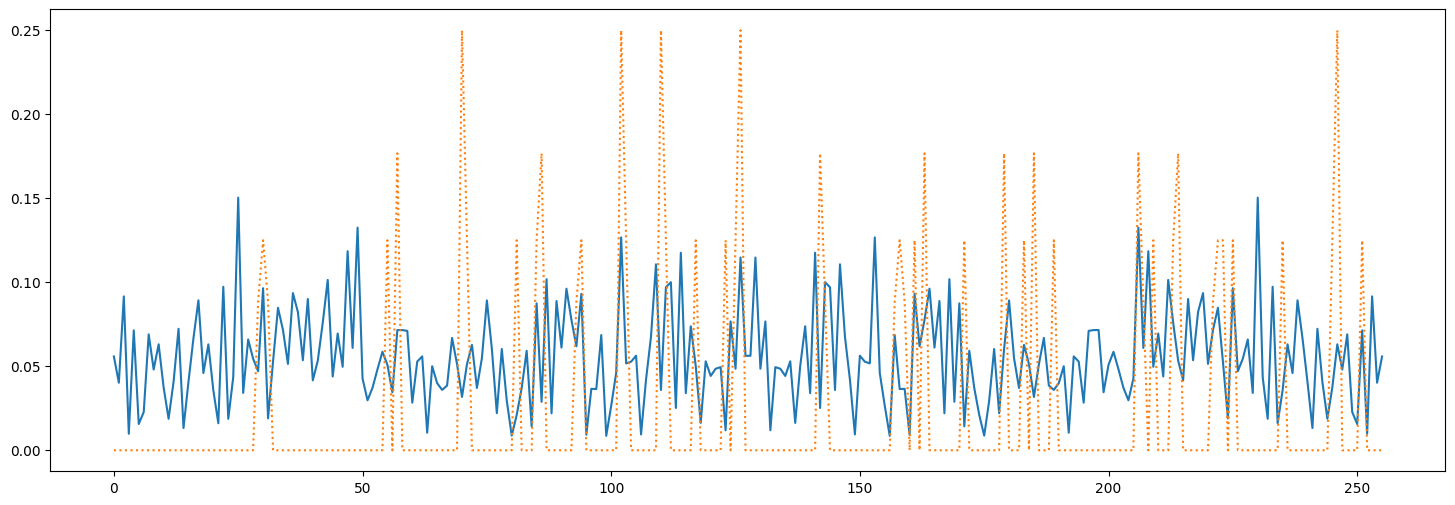

In [7]:
EpsiSampler = jVMC.sampler.ExactSampler(psi, (L,))
psi_s, psi_logPsi, psi_p = EpsiSampler.sample()
var_wf = np.abs(np.exp(psi_logPsi))[0]
var_wf /= var_wf.dot(var_wf)**0.5

figure = plt.figure(dpi=100, figsize=(18, 6))
plt.plot(data_at_time)#np.e?xp(chi(psi_s))[0]/sum(np.exp(2.*chi(psi_s))[0])**0.5)
# plt.plot(data_at_time)
plt.plot(var_wf,':')
#plt.plot(data_at_time)
#plt.ylim(0,.7)
plt.plot()

In [13]:
numSamples=2**18
sampled_s, psi_logPsi, psi_p = psiSampler.sample(numSamples=numSamples)

In [14]:
psi_histogram = (2**jnp.arange(L)*sampled_s[0]).sum(axis=-1)

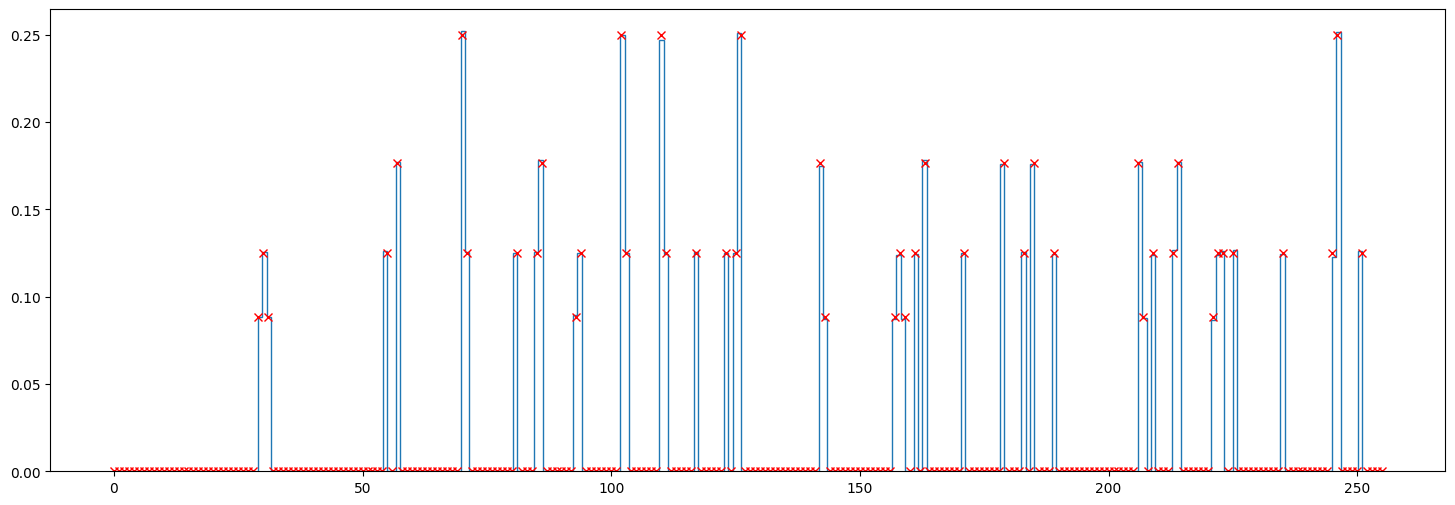

In [15]:
fig = plt.figure(dpi=100, figsize=(18, 6))
counts, bins = np.histogram(psi_histogram,bins=2**L)
plt.stairs(jnp.sqrt(counts/sum(counts)), bins)
#plt.stairs(chi_counts/max(chi_counts), chi_bins)
plt.plot(var_wf,'x',c='r')

In [11]:
EpsiSampler = jVMC.sampler.ExactSampler(psi, (L,))
psi_s, psi_logPsi, psi_p = EpsiSampler.sample()

In [12]:
jnp.sum(jnp.exp(2.*psi(psi_s).real),axis=-1)

Array([1.], dtype=float64)